<a href="https://colab.research.google.com/github/MayurBhama/21-Data-Science-Projects/blob/main/Project_05_Customer_Segmentation__with_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 5: Customer Segmentation with Clustering 🛍️

**Project Objective:** To use unsupervised machine learning to identify distinct groups of customers within a mall's dataset. By segmenting customers based on multiple dimensions (income, age, spending habits), we can provide rich, actionable insights to the marketing team for highly targeted campaigns.


### Core Concepts We'll Cover:
1.  **Unsupervised Learning:** Understanding the difference between supervised and unsupervised learning.
2.  **Clustering Fundamentals & K-Means:** A deep dive into how the K-Means algorithm works.
3.  **The Elbow Method:** A critical technique for finding the optimal number of clusters (`k`).
4.  **Multi-dimensional EDA:** Exploring relationships between all features using 2D and 3D plots.
5.  **Multiple Segmentation Models:** Building and interpreting different clustering models based on different feature sets.
6.  **Hierarchical Clustering:** A brief introduction to an alternative clustering method.
7.  **Data-Driven Personas:** Translating cluster statistics into actionable business strategies.

### **Theoretical Concept: What is Unsupervised Learning?**

So far, we have worked with **supervised learning**, where our datasets had a specific target variable we were trying to predict (e.g., `SalePrice`, `Survived`). The model *learns* the relationship between features and the known target.

**Unsupervised learning** is different. Here, we work with datasets that **do not have a target variable**. The goal is not to predict a known outcome, but to discover hidden patterns, structures, and relationships within the data itself.

**Clustering** is the most common type of unsupervised learning. The objective is to group data points into clusters, such that points within the same cluster are very similar to each other, and points in different clusters are very dissimilar.


### Step 1: Setup - Importing Libraries and Loading Data

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set plot style
sns.set_style('whitegrid')

Imagine you have a bunch of unsorted toys (your data points) and you want to group them into different boxes (your clusters) based on how similar they are. K-Means is like a helper that does this for you!

K-Means Algorithm: Grouping the Toys

* Choose how many boxes you want (Choose k): You decide beforehand how many groups you want to create. Let's say you want 3 boxes (so k=3).
* Place some "toy leaders" in the boxes (Initialize centroids): K-Means randomly picks 3 toys and places one in each box. These toys are the "leaders" or "centroids" of their boxes for now.
* Sort the toys by how close they are to the leaders (Assign points to clusters): K-Means looks at every single toy and figures out which "toy leader" it's closest to. It then puts each toy into the box with the closest leader.
* Find the new average location of the leaders (Update centroids): Once all the toys are in boxes, K-Means calculates the average location of all the toys in each box. These average locations become the new "toy leaders" or centroids.
* Repeat steps 3 and 4 until the leaders stop moving (Iterate until convergence): K-Means keeps repeating the sorting and leader-finding steps. It does this until the "toy leaders" don't move much anymore, meaning the groups are stable.
Once the algorithm stops, you have your toys sorted into k boxes (clusters), where the toys in each box are generally similar to each other.

In [66]:
#Load the dataset from the iser-provided file
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/Mall_Customers.csv')

print("Dataset loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

fatal: destination path '21-Days-21-Projects-Dataset' already exists and is not an empty directory.
Dataset loaded successfully.
Data shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Step 2: In-Depth Exploratory Data Analysis (EDA)
Before clustering, we must understand the features and their relationships to find the most promising dimensions for segmentation.

In [67]:
# Basic info and statistics
print("Dataset Info:")
df.info()

# Drop the CustomerID as it's just an identifier and not useful for clustering
df.drop('CustomerID', axis=1, inplace=True)

print("\nDescriptive Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Descriptive Statistics:
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     4

#### 2.1 Univariate Analysis (Feature Distributions)

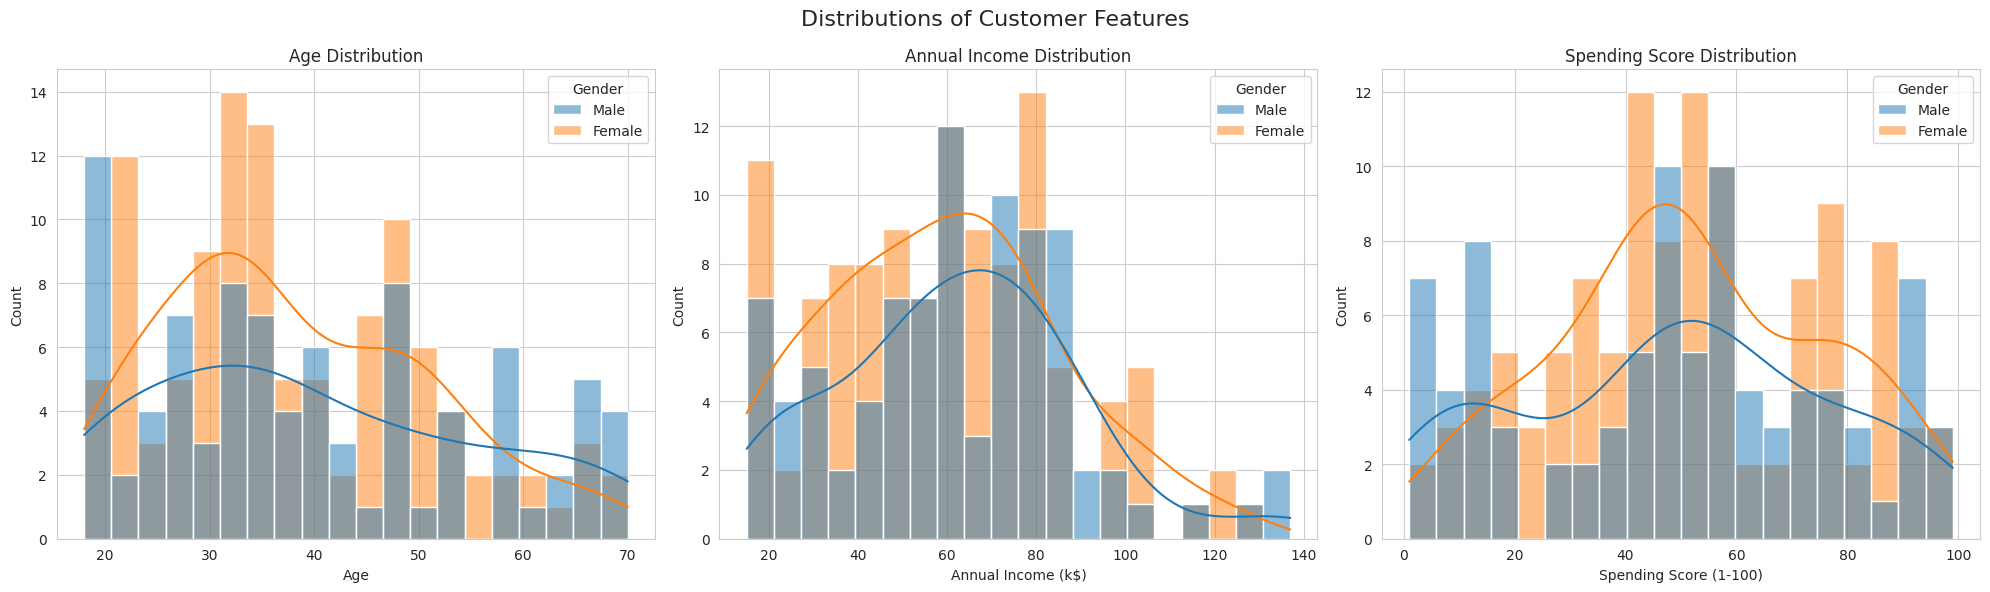

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distributions of Customer Features', fontsize=16)

sns.histplot(ax = axes[0], data = df, x = 'Age', kde = True, bins = 20, hue = 'Gender').set_title('Age Distribution')
sns.histplot(ax = axes[1], data = df, x = 'Annual Income (k$)', kde = True, bins = 20, hue = 'Gender').set_title('Annual Income Distribution')
sns.histplot(ax = axes[2], data = df, x = 'Spending Score (1-100)', kde = True, bins = 20, hue = 'Gender').set_title('Spending Score Distribution')

plt.tight_layout()
plt.show()

#### 2.2 Bivariate Analysis (Looking for Relationships)

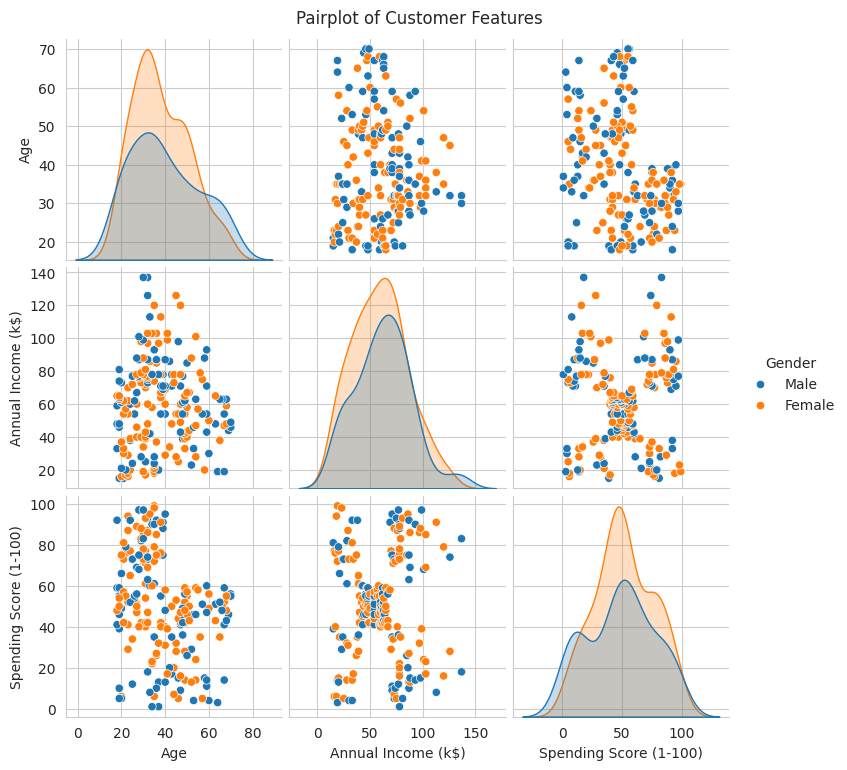

In [69]:
# Using pairplot to visualize relationships between all numerical variables
sns.pairplot(df, vars = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], hue = 'Gender', diag_kind= 'kde')
plt.suptitle('Pairplot of Customer Features', y = 1.02)
plt.show()

**CRITICAL INSIGHT from Pair Plot:**
- The **`Annual Income` vs. `Spending Score`** plot is the most revealing. It clearly shows distinct, blob-like groups, making it the perfect candidate for clustering.
- The **`Age` vs. `Spending Score`** plot shows some patterns but they are less defined. We see a concentration of high-spending customers in the younger age brackets.
- `Gender` does not appear to be a strong separating factor in any of these plots, as the distributions for males and females largely overlap.

#### 2.3 3D Visualization
Let's visualize the three most important features together in an interactive 3D plot to see if the clusters hold up.

In [70]:
fig = px.scatter_3d(
    df,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    z='Age',
    color='Gender',
    title='3D Visualization of Customer Features',
)
fig.show()

### Step 3: Segmentation Model 1 - Income & Spending Score
This is our primary segmentation model, focusing on the most promising features identified in the EDA.

## **Theoretical Concept: The Elbow Method**

How do we choose the best number of clusters (`k`) for our K-Means model? The **Elbow Method** is a common technique.

It works by calculating the **Within-Cluster Sum of Squares (WCSS)** for different values of `k` (typically from 1 to 10). WCSS is the sum of the squared distances between each point and the centroid of the cluster it belongs to. A lower WCSS means the points are closer to their cluster centroids, indicating tighter clusters.

We then plot WCSS against the number of clusters (`k`). As `k` increases, WCSS will always decrease (because each point gets closer to its assigned centroid). However, at some point, adding more clusters doesn't significantly reduce the WCSS. This point, where the rate of decrease sharply changes, looks like an "elbow" in the plot.

The **optimal number of clusters (`k`)** is typically chosen at this elbow point. It represents a good balance between having too few clusters (high WCSS) and too many clusters (overfitting and diminishing returns).

Here are the most common init options available:

* 'k-means++' (Default): This is the recommended method. It smarty initializes the centroids to be spread out from each other. This significantly improves the chances of finding a globally optimal solution and reduces the risk of converging to a suboptimal local minimum.
* 'random': This method chooses n_clusters observations (data points) randomly from the dataset and uses them as the initial centroids. While simple, it can sometimes lead to poor clustering results if the random initial centroids are not well-separated.
* A NumPy array: You can also provide a NumPy array with a shape of (n_clusters, n_features) that explicitly specifies the initial coordinates of the centroids. This is useful if you have prior knowledge about where the clusters should be located or if you want to replicate a specific initialization.

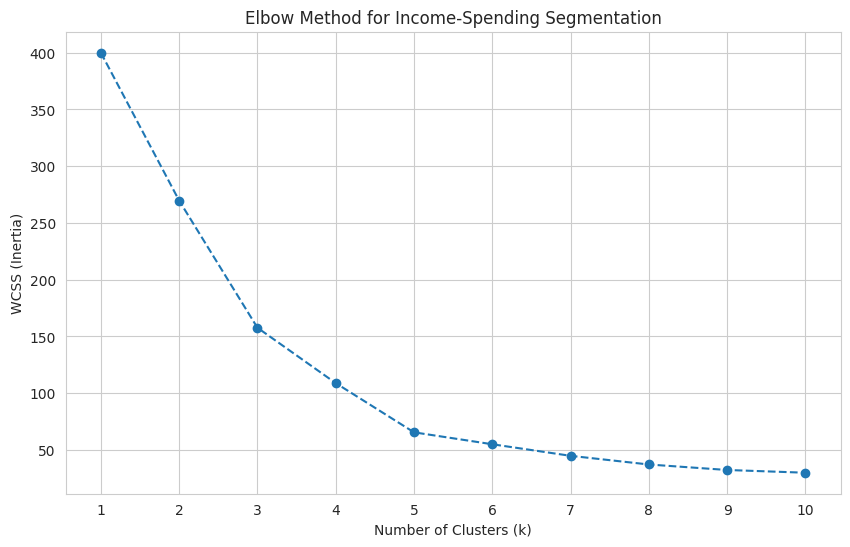

In [71]:
X1 = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

#2. Implement the Elbow Method
wcss1 = []
for k in range(1,11):
  kmeans = KMeans(n_clusters=k, init= 'k-means++', random_state = 42, n_init = 10)
  kmeans.fit(X1_scaled)
  wcss1.append(kmeans.inertia_)

#3. Plot the Elbow Curve
plt.figure(figsize = (10, 6))
plt.plot(range(1,11), wcss1 , marker = 'o', linestyle = '--')
plt.title('Elbow Method for Income-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

Imagine you've grouped your friends into different clubs (these are your clusters). WCSS helps you figure out how "together" or "spread out" the members are within each club.

Cluster: This is one of the groups you've formed.
Centroid: This is the "center point" of a cluster. Think of it as the average location of all the members in that club.
WCSS: For each cluster, you calculate the distance from every member in that cluster to the cluster's centroid. Then you square all these distances and add them up. You do this for all the clusters and add up the totals.
A low WCSS means that the points within each cluster are very close to their centroid. This suggests that the clusters are tight and well-defined.

A high WCSS means that the points within each cluster are more spread out from their centroid, indicating less distinct or looser clusters.

How WCSS relates to K-Means:

In K-Means, the algorithm's goal is to minimize the WCSS. It tries to find the best locations for the centroids and the best groupings of points so that the total WCSS is as small as possible.

The Elbow Method, which you saw in the notebook, uses WCSS to help choose the optimal number of clusters (k) for K-Means. You calculate the WCSS for different values of k and look for the "elbow" where the decrease in WCSS starts to slow down. This point suggests that adding more clusters doesn't significantly improve the "tightness" of the clusters.

##**Observation:**
The "elbow" of the curve is clearly at **k=5**. The WCSS decreases sharply until k=5, and then the rate of decrease flattens out. This confirms our visual intuition from the scatter plot!

In [72]:
#Build and fit the final model
kmeans1 = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42, n_init = 10)
df['Income_Cluster'] = kmeans1.fit_predict(X1_scaled)

#### 3.1 Visualizing and Interpreting the Income-Based Segments

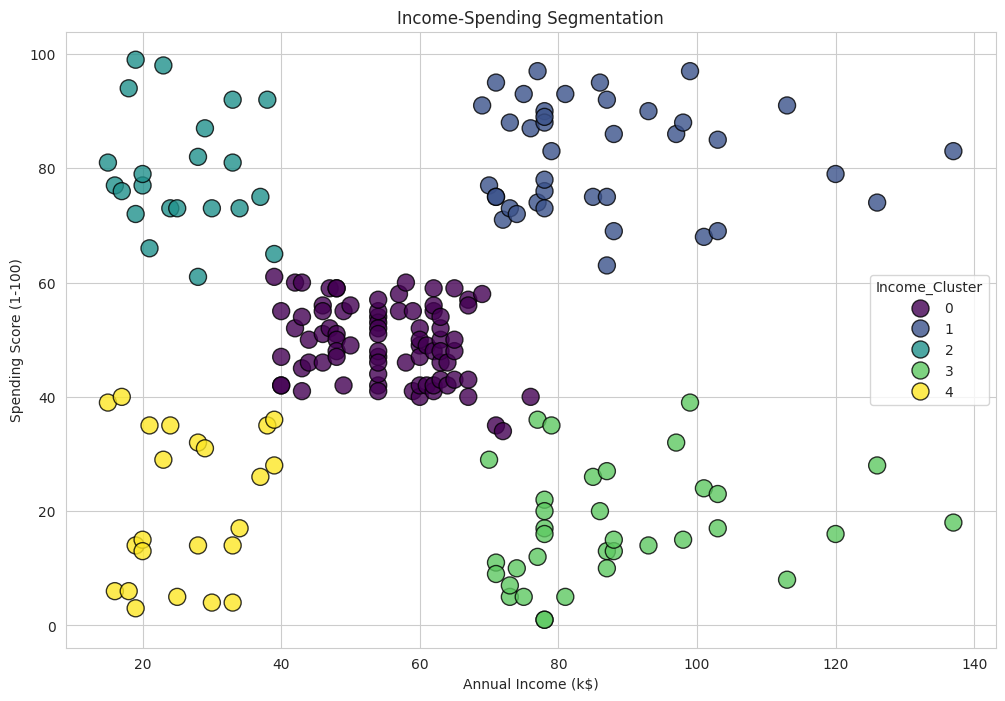

In [73]:
plt.figure(figsize = (12,8))
sns.scatterplot(data = df, x = 'Annual Income (k$)', y = 'Spending Score (1-100)', hue = 'Income_Cluster', palette='viridis' , s=150 , alpha=0.8, edgecolor='black')
plt.title('Income-Spending Segmentation')
plt.show()

In [74]:
#Quantitative persona analysis
cluster_profiles1 = df.groupby('Income_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
cluster_profiles1['Size'] = df['Income_Cluster'].value_counts()
print("----Income-Based Cluster Profiles----")
cluster_profiles1

----Income-Based Cluster Profiles----


,Age,Annual Income (k$),Spending Score (1-100),Size
Income_Cluster,,,,
0,42.72,55.30,49.52,81
1,32.69,86.54,82.13,39
2,25.27,25.73,79.36,22
3,41.11,88.20,17.11,35
4,45.22,26.30,20.91,23


#### 3.2 Income-Based Personas and Strategy
Using the quantitative profiles, we can define our segments:
- **Cluster 0 (Standard):** Average income (~55k) and spending (~50). This is the largest, core customer group.
- **Cluster 1 (Target - High Value):** High income (~87k) and high spending (~82). The mall's prime target.
- **Cluster 2 (Enthusiasts):** Low income (~26k) but high spending (~79). Likely young, trend-focused shoppers.
- **Cluster 3 (Careful High-Earners):** High income (~88k) but low spending (~17). Cautious, value-driven buyers.
- **Cluster 4 (Budget Shoppers):** Low income (~26k) and low spending (~21). Highly price-sensitive.


### Step 4: Segmentation Model 2 - Age & Spending Score
Let's create a different segmentation model to see if we can find age-related customer groups.

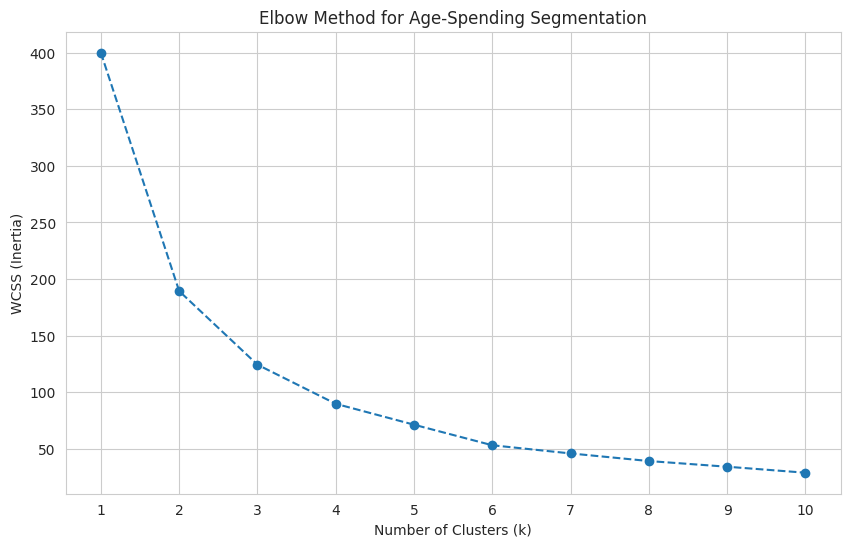

In [75]:
#1. Select and scale the features
X2 = df[['Age', 'Spending Score (1-100)']]
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

#2. Implement the ELbow Method
wcss2 = []
for k in range(1,11):
  kmeans = KMeans(n_clusters = k , init = 'k-means++', random_state = 42, n_init = 10)
  kmeans.fit(X2_scaled)
  wcss2.append(kmeans.inertia_)

#Plot the Elbow Curve
plt.figure(figsize = (10,6))
plt.plot(range(1,11), wcss2, marker = 'o', linestyle = '--')
plt.title('Elbow Method for Age-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

**Observation:** The elbow is less sharp here, but **k=4** appears to be a reasonable choice.

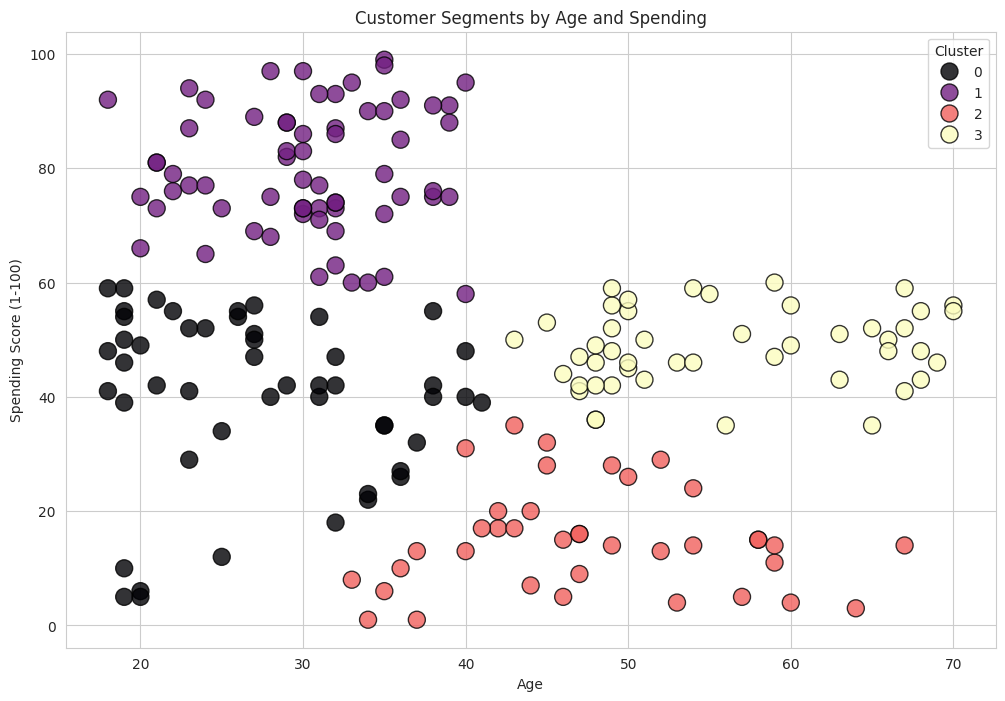

In [76]:
#Build and fit the final model for age segmentation
kmeans2 = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42, n_init = 10)
df['Age_Cluster'] = kmeans2.fit_predict(X2_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)',
                hue='Age_Cluster', palette='magma', s=150, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Age and Spending')
plt.legend(title='Cluster')
plt.show()

#### 4.1 Interpreting the Age-Based Segments
This model gives us a different perspective:
- **Young High-Spenders:** A clear group of customers under 40 with high spending scores.
- **Young Low-Spenders:** Customers under 40 with low-to-moderate spending.
- **Older Average-Spenders:** Customers over 40 with moderate spending scores.
- **Older Low-Spenders:** A small group of older customers with very low spending scores.

### Step 5: An Alternative Method - Hierarchical Clustering
To add more depth, let's briefly look at another clustering technique.

#### **Theoretical Concept: Hierarchical Clustering & Dendrograms**
Unlike K-Means, Hierarchical Clustering doesn't require us to specify the number of clusters beforehand. It builds a tree-like hierarchy of clusters.

We can visualize this hierarchy with a **dendrogram**. The dendrogram shows how clusters are merged (or split). To find the optimal number of clusters, we look for the tallest vertical line that doesn't cross any horizontal lines and draw a horizontal line through it. The number of vertical lines our new line crosses is the optimal number of clusters.


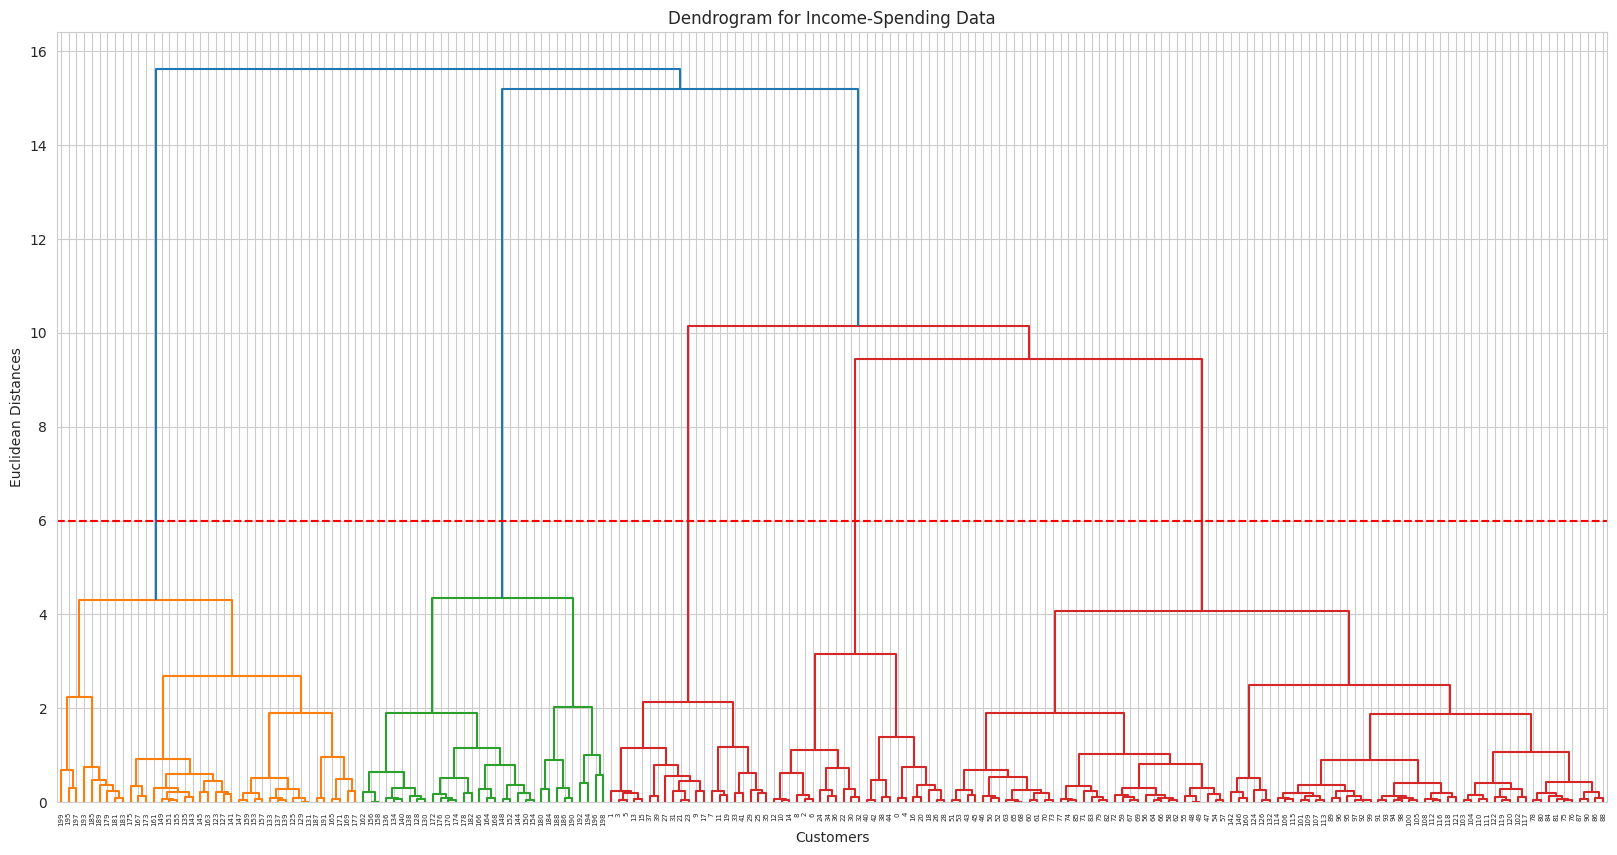

In [77]:
plt.figure(figsize = (20,10))
dendrogram = sch.dendrogram(sch.linkage(X1_scaled, method = 'ward'))
plt.title('Dendrogram for Income-Spending Data')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=6, color='r', linestyle='--') # Example cut-off line
plt.show()

**Insight:** The dendrogram also confirms that **5 clusters** is the optimal number for the income-spending data. If we draw a horizontal line at a height of 6 (as shown by the red dashed line), it crosses five vertical lines.

### Step 6: Conclusion

In this extended project, we successfully applied unsupervised machine learning to perform customer segmentation.

**Key Steps Undertaken:**
1.  **Performed an in-depth EDA:** Used 2D and 3D plots to explore customer data from multiple angles.
2.  **Built two distinct segmentation models:** Created an income-based model and an age-based model, showing that segmentation is not a one-size-fits-all process.
3.  **Used the Elbow Method** to programmatically determine the optimal number of clusters for each scenario.
4.  **Introduced Hierarchical Clustering** as an alternative method and used its dendrogram to validate our choice of `k`.
5.  **Created quantitative, data-driven personas** for each segment, providing the marketing team with precise, actionable insights for targeted campaigns.

This project highlights how different clustering approaches can uncover different facets of customer behavior, providing a richer, more nuanced understanding than a single model alone.

### Submission Criteria

Based on the project objectives and the insights gained from the initial analysis, here are the key criteria for your submission:

1.  **Explore Gender vs. Spending Score:** Analyze the relationship between 'Gender' and 'Spending Score (1-100)' to see if gender plays a significant role in spending habits. Visualizations and summary statistics would be helpful here.
2.  **Apply Feature Engineering for Clustering:** Create a new feature using existing data (Feature Engineering). Then, explore if clustering can be effectively performed using this newly engineered feature in combination with one or more existing features. Document the feature engineering process, the chosen features for clustering, the determination of the optimal number of clusters (e.g., using the Elbow Method), and the resulting cluster visualization and interpretation.

### Task 1: Explore Gender vs. Spending Score

In [78]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Income_Cluster,Age_Cluster
0,Male,19,15,39,4,0
1,Male,21,15,81,2,1
2,Female,20,16,6,4,0
3,Female,23,16,77,2,1
4,Female,31,17,40,4,0


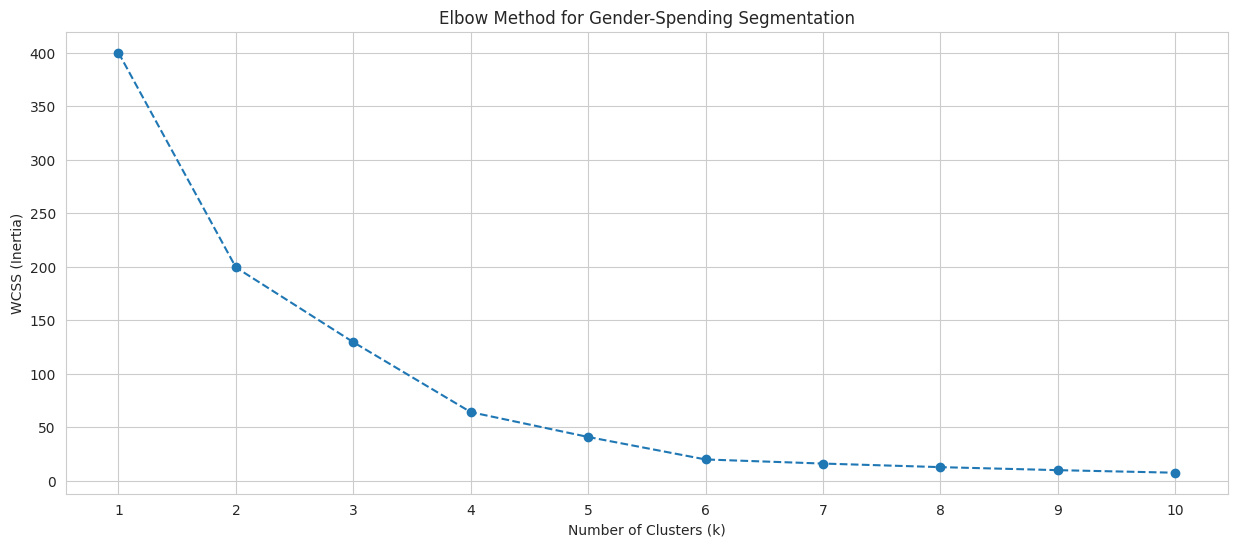

In [79]:
df['Gender'] = np.where(df['Gender'] == 'Male', 1, 0)


X3 = df[['Gender' , 'Spending Score (1-100)']]
scaler3 = StandardScaler()
X3_scaled = scaler3.fit_transform(X3)

wcss3 = []
for k in range(1,11):
  kmeans= KMeans(n_clusters = k, init = 'k-means++', random_state = 42, n_init = 10)
  kmeans.fit(X3_scaled)
  wcss3.append(kmeans.inertia_)

plt.figure(figsize = (15,6))
plt.plot(range(1,11), wcss3 , marker = 'o', linestyle = '--')
plt.title('Elbow Method for Gender-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

**Observation:** The elbow is less sharp here, but **k=4** appears to be a reasonable choice.

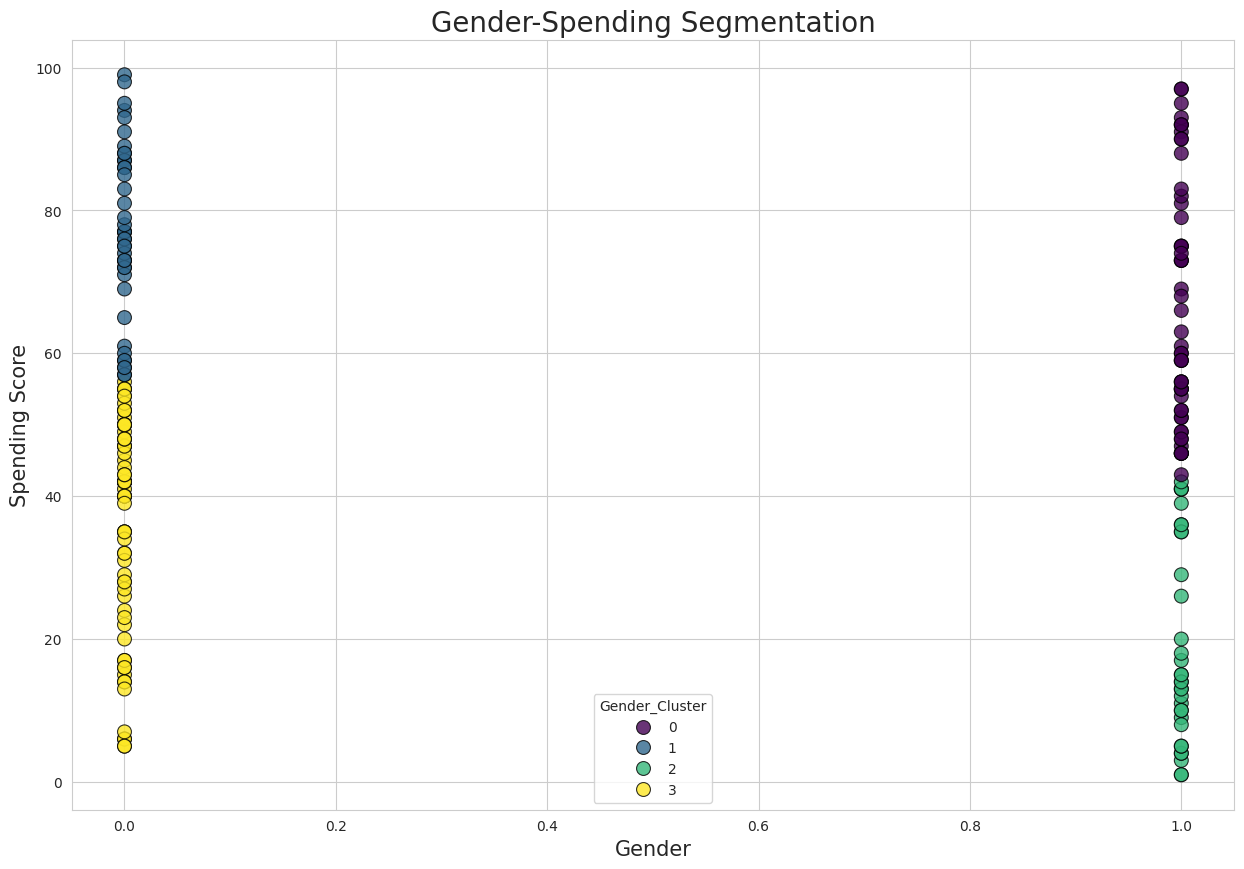

In [80]:
#Build THe final model
kmeans3 = KMeans(n_clusters=4, init = 'k-means++', random_state = 42 , n_init = 10)
df['Gender_Cluster'] = kmeans3.fit_predict(X3_scaled)

#Visualization
plt.figure(figsize = (15,10))
sns.scatterplot(data=df, x='Gender', y='Spending Score (1-100)',
                hue='Gender_Cluster',  # This remains the same
                palette = 'viridis', # Use a palette for 4 distinct colors
                s=100, alpha=0.8, edgecolor='black')
plt.title('Gender-Spending Segmentation', fontsize = 20)
plt.xlabel('Gender', fontsize = 15)
plt.ylabel('Spending Score', fontsize = 15)
plt.show()

The resulting clusters represent clear, actionable customer personas:

Cluster 0 (Dark Purple): This group consists of Males (Gender=1) with high spending scores (approximately 65 and above). These are your high-value male customers.

Cluster 1 (Blue/Teal): This group represents Females (Gender=0) with high spending scores (approximately 65 and above). These are your high-value female customers.

Cluster 2 (Greenish-Teal): This cluster contains Males (Gender=1) with low-to-mid spending scores (from 0 to ~65). This is the largest segment of male customers, representing the general male shopper.

Cluster 3 (Yellow): This cluster contains Females (Gender=0) with low-to-mid spending scores (from 0 to ~65). This is the largest segment of female customers, representing the general female shopper.

### 2.  **Apply Feature Engineering for Clustering:** Create a new feature using existing data (Feature Engineering). Then, explore if clustering can be effectively performed using this newly engineered feature in combination with one or more existing features. Document the feature engineering process, the chosen features for clustering, the determination of the optimal number of clusters (e.g., using the Elbow Method), and the resulting cluster visualization and interpretation.

In [81]:
#1.) Creating Income per Age Unit
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Income_Cluster,Age_Cluster,Gender_Cluster
0,1,19,15,39,4,0,2
1,1,21,15,81,2,1,0
2,0,20,16,6,4,0,3
3,0,23,16,77,2,1,1
4,0,31,17,40,4,0,3


In [84]:
df['Income_per_Age'] = df['Annual Income (k$)'] / df['Age']
df['Income_per_Age']
#High number indicates that the person is early large amount of money at a young age.

,Income_per_Age
0,0.789474
1,0.714286
2,0.800000
3,0.695652
4,0.548387
...,...
195,3.428571
196,2.800000
197,3.937500
198,4.281250


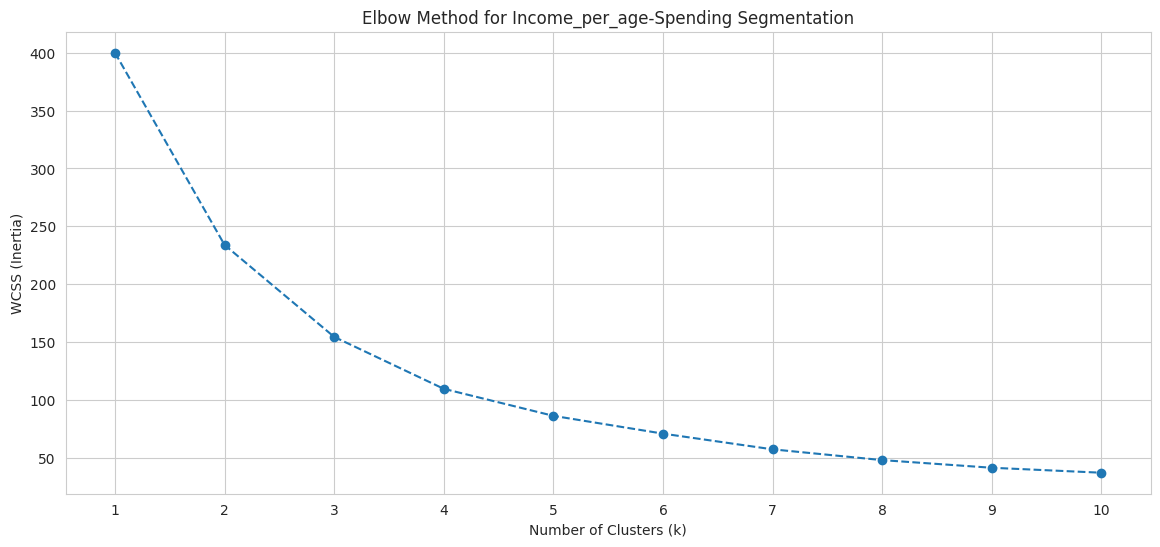

In [87]:
#Feature Scaling
X4 = df[['Income_per_Age', 'Spending Score (1-100)']]
scaler4 = StandardScaler()
X4_scaled = scaler4.fit_transform(X4)

#Elbow Method
wcss4 = []
for k in range(1,11):
  kmeans4 = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, random_state = 42)
  kmeans4.fit(X4_scaled)
  wcss4.append(kmeans4.inertia_)

plt.figure(figsize = (14,6))
plt.plot(range(1,11), wcss4, marker = 'o', linestyle = '--')
plt.title('Elbow Method for Income_per_age-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

From the graph i think maybe 3 or 4 k (Number of Clusters) value will be a great option

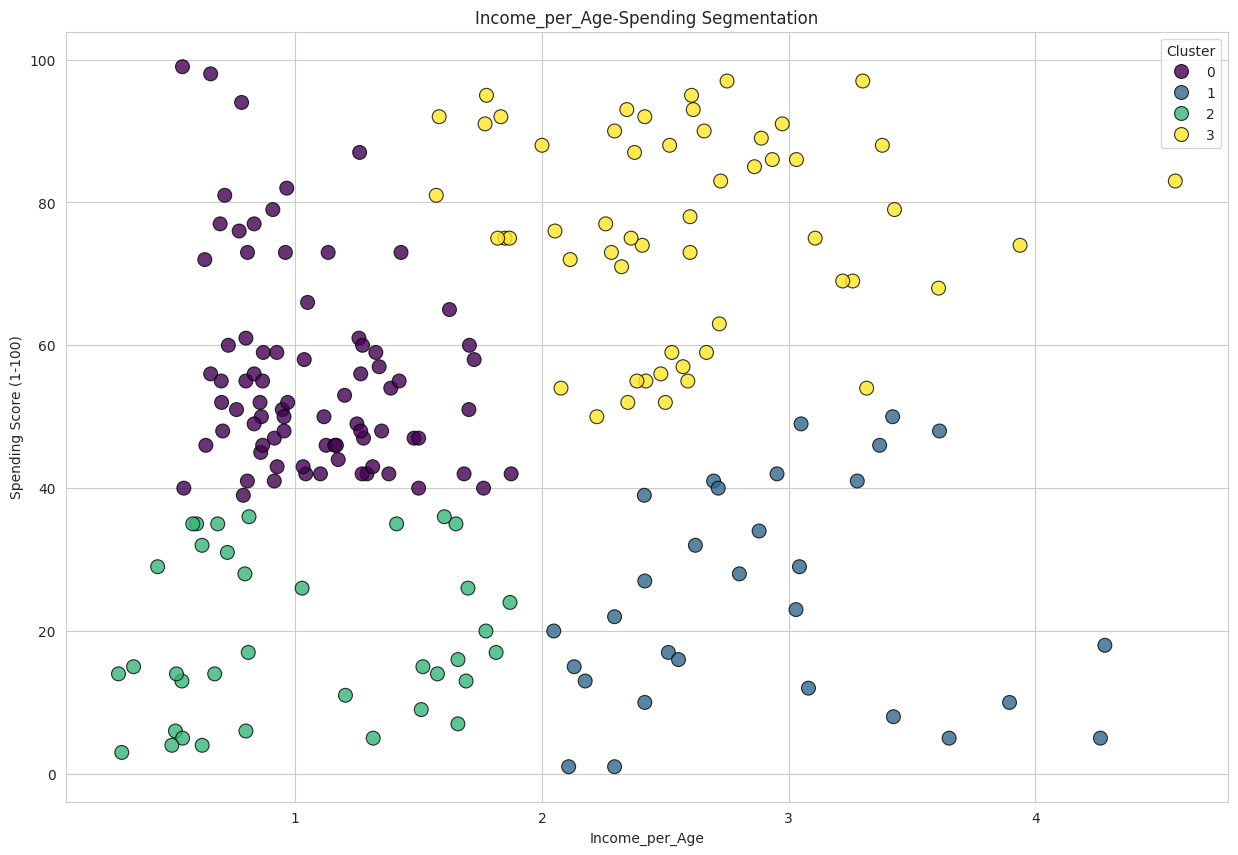

In [89]:
#BUilding the final model
kmeans4 = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, random_state = 42)
df['Income_per_Age_Cluster'] = kmeans4.fit_predict(X4_scaled)

#Visualize the clusters
plt.figure(figsize = (15,10))
sns.scatterplot(data = df, x = 'Income_per_Age', y = 'Spending Score (1-100)', hue = 'Income_per_Age_Cluster', palette = 'viridis', s = 100, alpha = 0.8, edgecolor = 'black')
plt.title('Income_per_Age-Spending Segmentation')
plt.legend(title = 'Cluster')
plt.xlabel('Income_per_Age')
plt.ylabel('Spending Score (1-100)')
plt.show()

# Interpretation:
### 1) Cluster 3 (Yellow): Prime Spenders
- These customers have a high Income per Age Unit and a very high Spending Score.

- This is the most valuable segment. They are likely young, high-earning professionals ("Young High-Fliers") who have significant disposable income and a strong willingness to spend it. They are driving a large portion of the mall's revenue.

- Strategy: Target them with premium products, new arrivals, and loyalty programs to retain their high value.


### 2) Cluster 1 (Blue): Cautious High-Earners
- This group also has a very high Income per Age Unit but, crucially, a low Spending Score.

- These are the "untapped potential" customers. They are high-earners, similar to the Prime Spenders, but are frugal, cautious, or perhaps prefer to save. They have the money but are not spending it.

- This group requires a different approach. Marketing should focus on quality, long-term value, and investment-worthy purchases rather than trendy or impulsive buys. The goal is to understand their barriers to spending and address them.


### 3) Cluster 0 (Dark Purple): Standard Consumers
- This segment has a low-to-average Income per Age Unit but a solid mid-to-high Spending Score.

- This is the mall's core customer base. They might be older individuals with stable careers or young adults who are comfortable spending what they earn. They are reliable, active shoppers.

- Engage this group with regular promotions, seasonal sales, and broad-appeal marketing to maintain their steady business.

### 4) Cluster 2 (Green): Frugal Shoppers
- This group has a low Income per Age Unit and a low Spending Score.

- These are the most price-sensitive customers. They are careful with their money, likely due to having modest incomes or a strong saving mindset.

- Target this segment with discounts, clearance sales, and value-focused promotions. The goal is to activate their spending with clear financial incentives.

# 2. Frugality Score
- This feature measures the gap between a customer's financial capacity and their spending behavior.Are they a "Saver" or a "Spender"

- Two people might earn $100k, but one spends cautiously while the other spends freely. This score quantifies that difference, revealing their underlying financial personality.

"""
- High Positive Score (e.g., > 50) = Savers
- Score Around Zero = Balanced Consumers
- Negative Score = They have a spending score that is much higher than their income.

"""

In [92]:
#2) Frugality Score
df['Frugality_Score'] = df['Annual Income (k$)'] - df['Spending Score (1-100)']
df['Frugality_Score']
"""
High Positive Score (e.g., > 50) = Savers
Score Around Zero = Balanced Consumers
Negative Score = They have a spending score that is much higher than their income.
"""

'\nHigh Positive Score (e.g., > 50) = Savers\nScore Around Zero = Balanced Consumers\nNegative Score = They have a spending score that is much higher than their income.\n'

In [95]:
X5 = df[['Frugality_Score' , 'Age']]
scaler5 = StandardScaler()
X5_scaled = scaler5.fit_transform(X5)

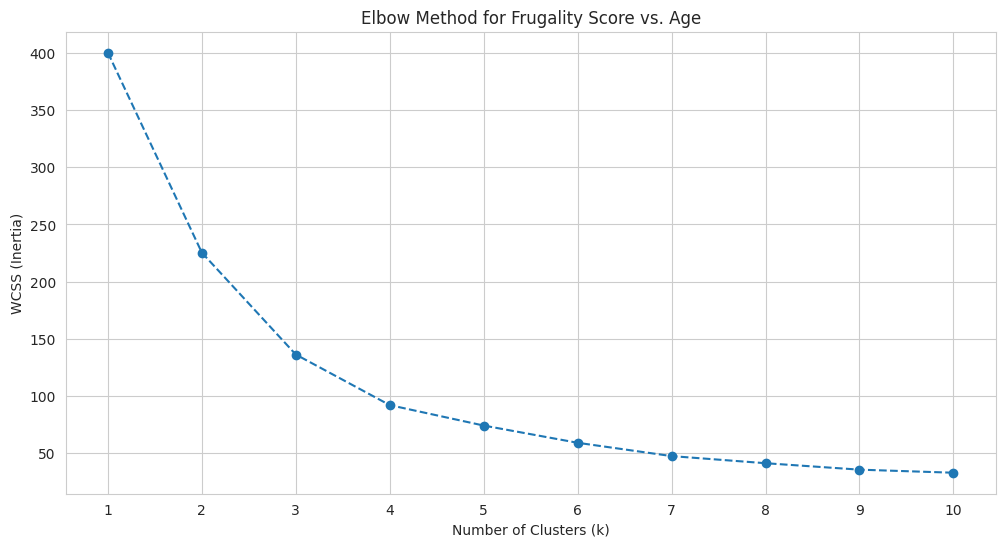

In [96]:
#Elbow Method
wcss5 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X5_scaled)
    wcss5.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), wcss5, marker='o', linestyle='--')
plt.title('Elbow Method for Frugality Score vs. Age')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

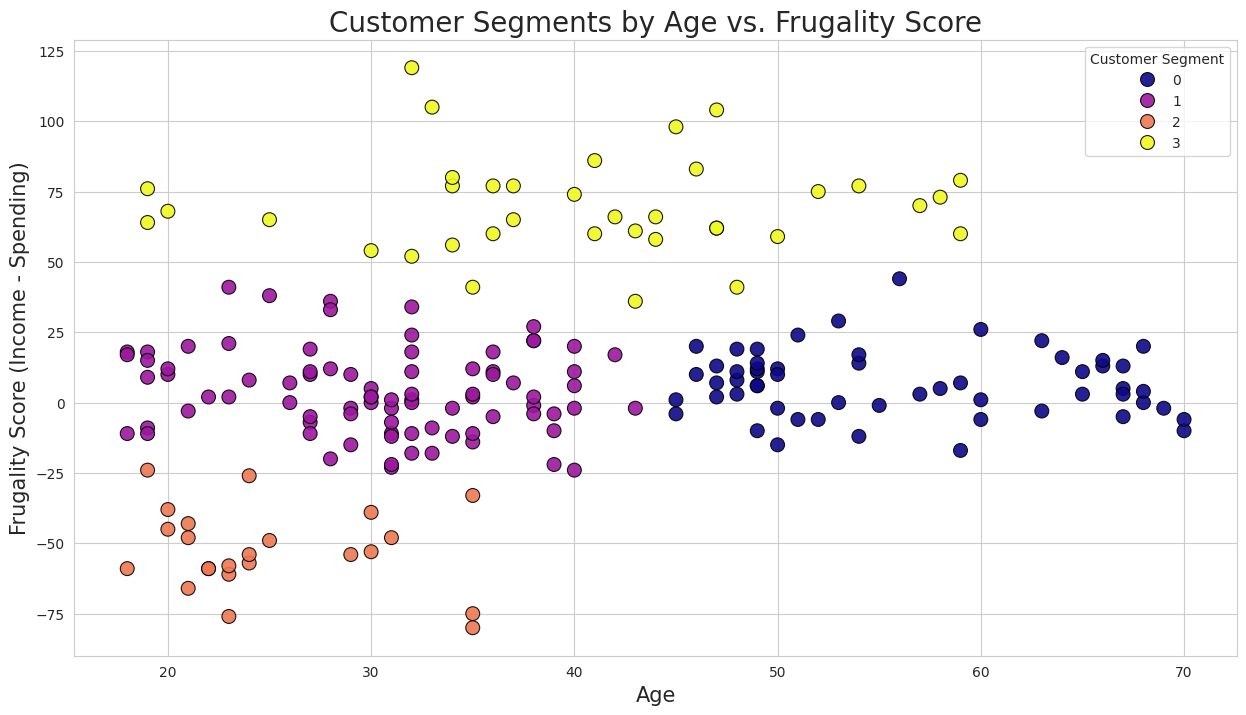


High Positive Score (e.g., > 50) = Savers
Score Around Zero = Balanced Consumers
Negative Score = They have a spending score that is much higher than their income.



In [98]:
#Building final model
kmeans5 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Frugality_Cluster'] = kmeans5.fit_predict(X5_scaled)

#Visualization
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='Age', y='Frugality_Score',
                hue='Frugality_Cluster', palette='plasma',
                s=100, alpha=0.9, edgecolor='black')

plt.title('Customer Segments by Age vs. Frugality Score', fontsize=20)
plt.xlabel('Age', fontsize=15)
plt.ylabel('Frugality Score (Income - Spending)', fontsize=15)
plt.legend(title='Customer Segment')
plt.show()

print("""
High Positive Score (e.g., > 50) = Savers
Score Around Zero = Balanced Consumers
Negative Score = They have a spending score that is much higher than their income.
""")

# Interpretation:
### Cluster 1 (Orange): Young Spendthrifts:
- These are young customers (typically under 35) with a very low, often negative, Frugality Score.
- This group's spending significantly outpaces their income. They are likely students or young professionals in the early stages of their careers, heavily influenced by trends and possibly relying on credit.
- This segment is highly responsive to fast-fashion, social media marketing, and "buy now, pay later" offers. The key is to capture their impulsive buying behavior.

### Cluster 0 (Purple): Young & Balanced:
- These customers are also on the younger side (mostly under 45) but have a Frugality Score centered around zero.
- Their spending is well-aligned with their income. They represent the typical young adult consumer who is building a career and managing a budget.
-  Target them with lifestyle brands, tech gadgets, and products related to career and personal development. They are a stable and growing consumer base.

### Cluster 2 (Dark Blue): Established & Balanced:
- This group consists of older customers (over 45) with a Frugality Score that is also near zero.
- Similar to the "Young & Balanced" group, their spending matches their income, but they are at a more mature and financially stable stage of life. They are the predictable, core customer base.
- Engage this segment with loyalty programs, family-oriented products, and marketing that emphasizes reliability and brand trust.

### Cluster 3 (Yellow): Established Savers:
- These are mid-to-late-career customers (mostly over 30) with a very high Frugality Score.
- This group's income is substantially higher than their spending, identifying them as cautious savers with significant untapped spending power. They are financially secure and prioritize saving over spending.
- This is a high-potential segment. They are not swayed by discounts but can be convinced by quality, durability, and long-term value. Target them with luxury goods, investment-worthy items, and premium services.

#3. Creating Age Groups

In [102]:
print(df['Age'].min())
print(df['Age'].max())

18
70


In [105]:
bins = [17,25,35,50,70]
labels = ['Young_Adult', 'Young_Pro', 'Established', 'Senior'] #'18-25 (Young Adult)', '26-35 (Young Pro)', '36-50 (Established)', '51+ (Senior)'
df['Age_Group'] = pd.cut(df['Age'], bins = bins, labels = labels, right = True)

print("Feature 'Age_Group' created successfully:")
print(df[['Age', 'Age_Group']].head(10))

Feature 'Age_Group' created successfully:
   Age    Age_Group
0   19  Young_Adult
1   21  Young_Adult
2   20  Young_Adult
3   23  Young_Adult
4   31    Young_Pro
5   22  Young_Adult
6   35    Young_Pro
7   23  Young_Adult
8   64       Senior
9   30    Young_Pro


In [109]:
#One hot encoding
age_group_dummies = pd.get_dummies(df['Age_Group'], dtype = int)
df_encoded = pd.concat([df, age_group_dummies], axis=1)

features_for_clustering = ['Spending Score (1-100)'] + list(labels)
X6 = df_encoded[features_for_clustering]
scaler6 = StandardScaler()
X6_scaled = scaler6.fit_transform(X6)

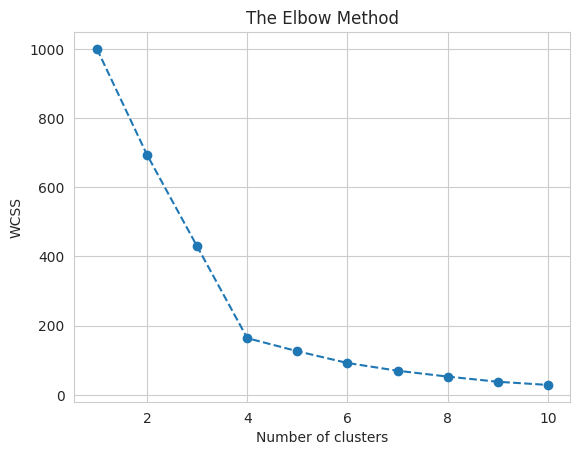

In [111]:
#Elbow Method
wcss6 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X6_scaled)
    wcss6.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss6, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

From the sharp graph we can easily select k value as 4

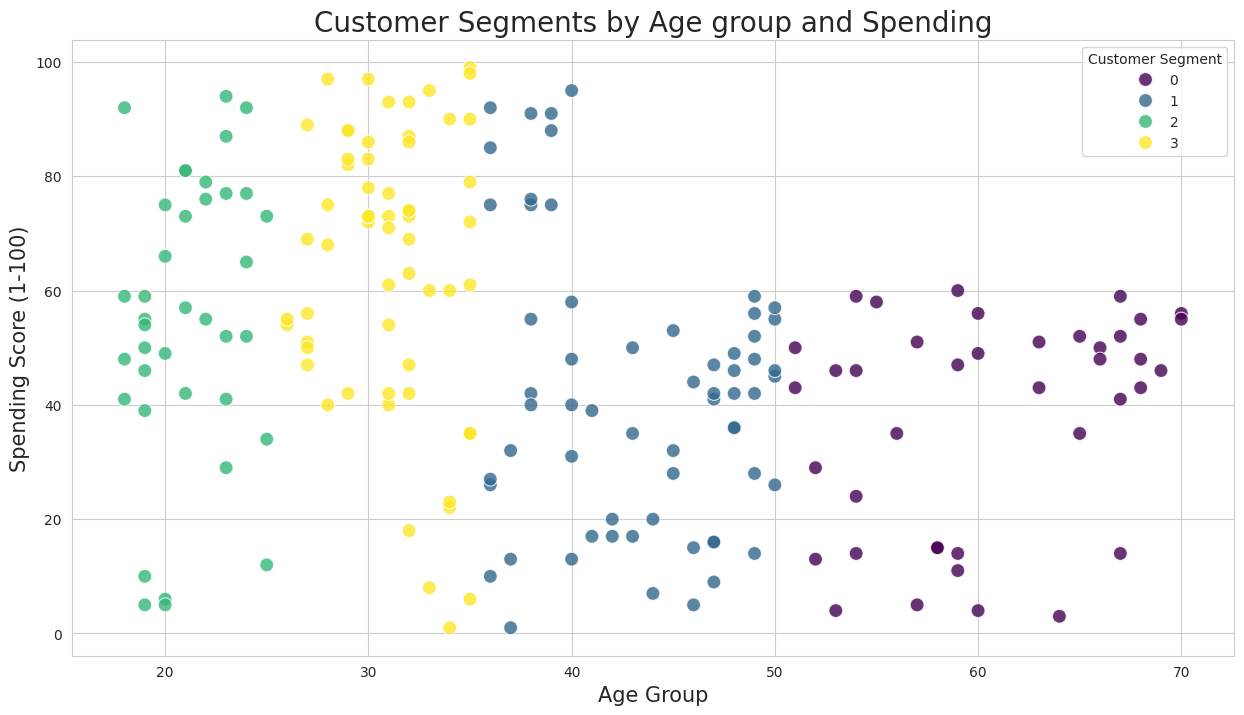

18-25 (Young Adult) 
26-35 (Young Pro) 
36-50 (Established) 
51+ (Senior)


In [114]:
#Final moddel
kmeans6 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Age_Group_Cluster'] = kmeans6.fit_predict(X6_scaled)

#Visualization
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)',
                hue='Age_Group_Cluster', palette='viridis',
                s=100, alpha=0.8)
plt.title('Customer Segments by Age group and Spending', fontsize=20)
plt.xlabel('Age Group', fontsize=15)
plt.ylabel('Spending Score (1-100)', fontsize=15)
plt.legend(title='Customer Segment')
plt.show()

print('18-25 (Young Adult)', '\n26-35 (Young Pro)', '\n36-50 (Established)', '\n51+ (Senior)')

#Interpretation:
### Cluster 3 (Yellow): Prime-Time Spenders:
- These customers are mostly between 25 and 40 years old and have a consistently high spending score (typically above 60).
- This is the mall's most valuable segment. They are "Young Professionals" and "Established Adults" in their prime earning years with a high propensity to spend on lifestyle, fashion, and premium goods.
- This group is the primary target for marketing new arrivals, premium brands, and exclusive offers. Retaining their loyalty is critical for maximizing revenue.

### Cluster 2 (Green): Young & Diverse:
- This segment consists of the youngest customers (under 25) and exhibits a wide range of spending scores, from very low to very high.
- These are "Young Adults," likely students or those in their first jobs. This group is not monolithic; it contains both frugal individuals and high-spending trend-followers.
- This group requires a dual approach. Target the high spenders with social media trends and fast-fashion, while engaging the lower spenders with student discounts and value-oriented promotions.

### Cluster 1 (Blue): Mid-Career Moderates:
- These are middle-aged customers (roughly 35-55) with a low-to-moderate spending score (generally below 60).
- These are "Established Adults" who are likely financially stable but have become more cautious or balanced in their spending, possibly due to family and financial commitments like mortgages.
- Engage this group with promotions for family-oriented products, household goods, and reliable brands. Loyalty programs are effective here.

### Cluster 0 (Dark Purple): Seniors with Varied Tastes:
- This segment comprises the oldest customers (50+) and, like the youngest group, shows a wide, but generally moderate, range of spending.
- These are "Seniors" who have diverse financial situations and needs. The cluster includes both frugal retirees and those who spend moderately on lifestyle and leisure.
- This group is less likely to be swayed by trends. Marketing should focus on comfort, quality, and services. They represent a stable, though not high-spending, customer base.
